In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import keras.layers as layers
import keras.optimizers as optimizers
from keras.models import Model, load_model
from keras.callbacks import LambdaCallback, ModelCheckpoint, ReduceLROnPlateau
import seaborn as sns
from PIL import Image
from skimage.transform import resize

import threading, random, os
from keras.utils.np_utils import to_categorical
from tensorflow.keras import optimizers

# Load Dataset

In [2]:
imgs = np.load('dataset/imgs_uint8.npy', allow_pickle=True).astype(np.float32) / 255.
labels = np.load('dataset/labels_uint8.npy', allow_pickle=True).astype(np.float32) / 255.
waldo_sub_imgs = np.load('dataset/waldo_sub_imgs_uint8.npy', allow_pickle=True) / 255.
waldo_sub_labels = np.load('dataset/waldo_sub_labels_uint8.npy', allow_pickle=True) / 255.

print(imgs.shape, labels.shape)
print(waldo_sub_imgs.shape, waldo_sub_labels.shape)

(18, 1760, 2800, 3) (18, 1760, 2800)
(18,) (18,)


# Data Generator
Random crop, random flip

In [3]:
PANNEL_SIZE = 224

class BatchIndices(object):
    """
    Generates batches of shuffled indices.
    # Arguments
        n: number of indices
        bs: batch size
        shuffle: whether to shuffle indices, default False 
    
    """
    def __init__(self, n, bs, shuffle=False):
        self.n,self.bs,self.shuffle = n,bs,shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res
        
class segm_generator(object):
    """
    Generates batches of sub-images.
    # Arguments
        x: array of inputs
        y: array of targets
        bs: batch size
        out_sz: dimension of sub-image
        train: If true, will shuffle/randomize sub-images
        waldo: If true, allow sub-images to contain targets.
    """
    def __init__(self, x, y, bs=64, out_sz=(224,224), train=True, waldo=True):
        self.x, self.y, self.bs, self.train = x,y,bs,train
        self.waldo = waldo
        self.n = x.shape[0]
        self.ri, self.ci = [], []
        for i in range(self.n):
            ri, ci, _ = x[i].shape
            self.ri.append(ri), self.ci.append(ci) 
        self.idx_gen = BatchIndices(self.n, bs, train)
        self.ro, self.co = out_sz
        self.ych = self.y.shape[-1] if len(y.shape)==4 else 1

    def get_slice(self, i,o):
        start = random.randint(0, i-o) if self.train else (i-o)
        return slice(start, start+o)

    def get_item(self, idx):
        slice_r = self.get_slice(self.ri[idx], self.ro)
        slice_c = self.get_slice(self.ci[idx], self.co)
        x = self.x[idx][slice_r, slice_c]
        y = self.y[idx][slice_r, slice_c]
        if self.train and (random.random()>0.5): 
            y = y[:,::-1]
            x = x[:,::-1]
        if not self.waldo and np.sum(y)!=0:
            return None

        return x, to_categorical(y, num_classes=2).reshape((y.shape[0] * y.shape[1], 2))

    def __next__(self):
        idxs = self.idx_gen.__next__()
        items = []
        for idx in idxs:
            item = self.get_item(idx)
            if item is not None:
                items.append(item)
        if not items:
            return None
        xs,ys = zip(*tuple(items))
        return np.stack(xs), np.stack(ys)
        
def seg_gen_mix(x1, y1, x2, y2, tot_bs=4, prop=0.34, out_sz=(224,224), train=True):
    """
    Mixes generator output. The second generator is set to skip images that contain any positive targets.
    # Arguments
        x1, y1: input/targets for waldo sub-images
        x2, y2: input/targets for whole images
        tot_bs: total batch size
        prop: proportion of total batch size consisting of first generator output
    """
    n1 = int(tot_bs*prop)
    n2 = tot_bs - n1
    sg1 = segm_generator(x1, y1, n1, out_sz = out_sz ,train=train)
    sg2 = segm_generator(x2, y2, n2, out_sz = out_sz ,train=train, waldo=False)
    while True:
        out1 = sg1.__next__()
        out2 = sg2.__next__()
        if out2 is None:
            yield out1
        else:
            yield np.concatenate((out1[0], out2[0])), np.concatenate((out1[1], out2[1]))

# Preview Sample Pannel Images

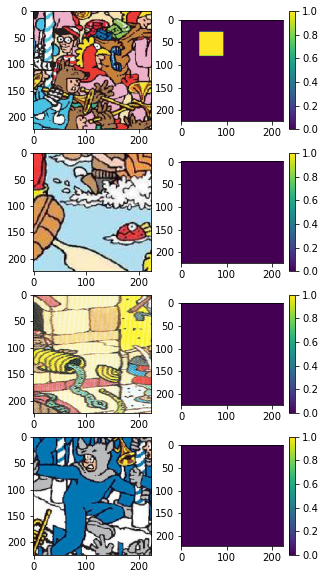

In [4]:
# waldo : not_waldo = 1 : 2 (0.34)
gen_mix = seg_gen_mix(waldo_sub_imgs, waldo_sub_labels, imgs, labels, tot_bs=4, prop=0.34, out_sz=(PANNEL_SIZE, PANNEL_SIZE))

X, y = next(gen_mix)

plt.figure(figsize=(5, 10))
for i, img in enumerate(X):
    plt.subplot(X.shape[0], 2, 2*i+1)
    plt.imshow(X[i])
    plt.subplot(X.shape[0], 2, 2*i+2)
    plt.colorbar()
    plt.imshow(y[i][:,1].reshape((PANNEL_SIZE, PANNEL_SIZE)))

# Plot Y-Data Distribution
Too many 0 values, so we make class weight to control biased(skewed) sample.  
See https://keras.io/models/sequential/ class_weight in fit_generator() section

88666846 37154


C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

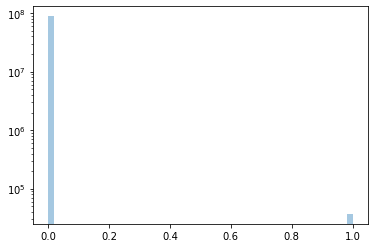

In [5]:
freq0 = np.sum(labels==0)
freq1 = np.sum(labels==1)

print(freq0, freq1)

sns.distplot(labels.flatten(), kde=False, hist_kws={'log':True})

# Make Class Weights (0 and 1)

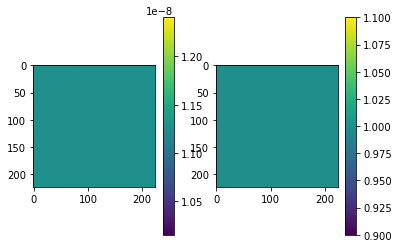

In [6]:
sample_weights = np.zeros((6, PANNEL_SIZE * PANNEL_SIZE, 2))

sample_weights[:,:,0] = 1. / freq0
sample_weights[:,:,1] = 1.

plt.subplot(1,2,1)
plt.imshow(sample_weights[0,:,0].reshape((224, 224)))
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(sample_weights[0,:,1].reshape((224, 224)))
plt.colorbar()

# Create Model

In [7]:
inputs = layers.Input(shape=(PANNEL_SIZE, PANNEL_SIZE, 3))

net = layers.Conv2D(64, kernel_size=3, padding='same')(inputs)
# net = layers.Activation('relu')(net)
net = layers.LeakyReLU()(net)
net = layers.MaxPool2D(pool_size=2)(net)

shortcut_1 = net

net = layers.Conv2D(128, kernel_size=3, padding='same')(net)
# net = layers.Activation('relu')(net)
net = layers.LeakyReLU()(net)
net = layers.MaxPool2D(pool_size=2)(net)

shortcut_2 = net

net = layers.Conv2D(256, kernel_size=3, padding='same')(net)
# net = layers.Activation('relu')(net)
net = layers.LeakyReLU()(net)
net = layers.MaxPool2D(pool_size=2)(net)

shortcut_3 = net

net = layers.Conv2D(256, kernel_size=1, padding='same')(net)
# net = layers.Activation('relu')(net)
net = layers.LeakyReLU()(net)
net = layers.MaxPool2D(pool_size=2)(net)

net = layers.UpSampling2D(size=2)(net)
net = layers.Conv2D(256, kernel_size=3, padding='same')(net)
net = layers.Activation('relu')(net)

net = layers.Add()([net, shortcut_3])

net = layers.UpSampling2D(size=2)(net)
net = layers.Conv2D(128, kernel_size=3, padding='same')(net)
net = layers.Activation('relu')(net)

net = layers.Add()([net, shortcut_2])

net = layers.UpSampling2D(size=2)(net)
net = layers.Conv2D(64, kernel_size=3, padding='same')(net)
net = layers.Activation('relu')(net)

net = layers.Add()([net, shortcut_1])

net = layers.UpSampling2D(size=2)(net)
net = layers.Conv2D(2, kernel_size=1, padding='same')(net)

net = layers.Reshape((-1, 2))(net)
net = layers.Activation('softmax')(net)

model = Model(inputs=inputs, outputs=net)

model.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizers.Adam(), 
    metrics=['acc'], 
    sample_weight_mode='temporal'
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 224, 224, 64  0           ['conv2d[0][0]']                 
                                )                                                             

# Train

In [8]:
gen_mix = seg_gen_mix(waldo_sub_imgs, waldo_sub_labels, imgs, labels, tot_bs=6, prop=0.34, out_sz=(PANNEL_SIZE, PANNEL_SIZE))

def on_epoch_end(epoch, logs):
    print('\r', 'Epoch:%5d - loss: %.4f - acc: %.4f' % (epoch, logs['loss'], logs['acc']), end='')

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

history = model.fit(
    gen_mix, steps_per_epoch=6, epochs=500, 
    verbose=0,
    callbacks=[
        print_callback,
        ReduceLROnPlateau(monitor='loss', factor=0.2, patience=100, verbose=1, mode='auto', min_lr=1e-05)
    ]
)

model.save('model.h5')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('loss')
plt.plot(history.history['loss'])
plt.subplot(1, 2, 2)
plt.title('accuracy')
plt.plot(history.history['acc'])

 Epoch:  362 - loss: 0.0048 - acc: 0.9980

KeyboardInterrupt: 

# Evaluation

In [ ]:
img_filename = '02.jpg'
test_img = np.array(Image.open(os.path.join('test_imgs', img_filename)).resize((2800, 1760), Image.NEAREST)).astype(np.float32) / 255.

plt.figure(figsize=(20, 10))
plt.imshow(test_img)

# Helper Functions (Resize, Split, Combine Pannels)

In [ ]:
def img_resize(img):
    h, w, _ = img.shape
    nvpanels = int(h/PANNEL_SIZE)
    nhpanels = int(w/PANNEL_SIZE)
    new_h, new_w = h, w
    if nvpanels*PANNEL_SIZE != h:
        new_h = (nvpanels+1)*PANNEL_SIZE
    if nhpanels*PANNEL_SIZE != w:
        new_w = (nhpanels+1)*PANNEL_SIZE
    if new_h == h and new_w == w:
        return img
    else:
        return resize(img, output_shape=(new_h, new_w), preserve_range=True)

def split_panels(img):
    h, w, _ = img.shape
    num_vert_panels = int(h/PANNEL_SIZE)
    num_hor_panels = int(w/PANNEL_SIZE)
    panels = []
    for i in range(num_vert_panels):
        for j in range(num_hor_panels):
            panels.append(img[i*PANNEL_SIZE:(i+1)*PANNEL_SIZE,j*PANNEL_SIZE:(j+1)*PANNEL_SIZE])
    return np.stack(panels)

def combine_panels(img, panels):
    h, w, _ = img.shape
    num_vert_panels = int(h/PANNEL_SIZE)
    num_hor_panels = int(w/PANNEL_SIZE)
    total = []
    p = 0
    for i in range(num_vert_panels):
        row = []
        for j in range(num_hor_panels):
            row.append(panels[p])
            p += 1
        total.append(np.concatenate(row, axis=1))
    return np.concatenate(total, axis=0)

# Preprocess Image

In [ ]:
test_img = img_resize(test_img)

panels = split_panels(test_img)

out = combine_panels(test_img, panels)

print(panels.shape, test_img.shape, out.shape)

# plt.imshow(panels[67])

# Predict

In [ ]:
model = load_model('model.h5')

pred_panels = model.predict(panels).reshape((-1, PANNEL_SIZE, PANNEL_SIZE, 2))[:, :, :, 1]

pred_out = combine_panels(test_img, pred_panels)

# compute coordinates and confidence
argmax_x = np.argmax(np.max(pred_out, axis=0), axis=0)
argmax_y = np.argmax(np.max(pred_out, axis=1), axis=0)
confidence = np.amax(pred_out) * 100

print('(%s, %s) %.2f%%' % (argmax_x, argmax_y, confidence))

plt.figure(figsize=(20, 10))
plt.imshow(pred_out)
plt.colorbar()

# Make Overlay for Result

In [ ]:
def bbox_from_mask(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    y1, y2 = np.where(rows)[0][[0, -1]]
    x1, x2 = np.where(cols)[0][[0, -1]]
    return x1, y1, x2, y2

x1, y1, x2, y2 = bbox_from_mask((pred_out > 0.8).astype(np.uint8))
print(x1, y1, x2, y2)

# make overlay
overlay = np.repeat(np.expand_dims(np.zeros_like(pred_out, dtype=np.uint8), axis=-1), 3, axis=-1)
alpha = np.expand_dims(np.full_like(pred_out, 255, dtype=np.uint8), axis=-1)

overlay = np.concatenate([overlay, alpha], axis=-1)

overlay[y1:y2, x1:x2, 3] = 0

plt.figure(figsize=(20, 10))
plt.imshow(overlay)

# Final Result

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.imshow(test_img)
ax.imshow(overlay, alpha=0.5)

rect = patches.Rectangle((x1, y1), width=x2-x1, height=y2-y1, linewidth=1.5, edgecolor='r', facecolor='none')
ax.add_patch(rect)

ax.set_axis_off()

fig.savefig(os.path.join('test_result', img_filename), bbox_inches='tight')